In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
# %matplotlib inline
matplotlib.use('Qt5Agg')
%matplotlib qt

In [3]:

from SGanalysis.SGobject import SGobject

In [6]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'

# roi_2
roi_name = 'roi_2'

In [7]:
## import segmentation

from SGanalysis.SGobject import SGobject

# Create an instance of SGobject
sg_obj = SGobject()

# Convert a TIFF image to polygons and store them in a GeoDataFrame
print("Running mask_to_objects...")
sg_obj.mask_to_objects(f'{filepath}{roi_name}/segmentations/segmentation_1_nuclei.tiff')

Running mask_to_objects...


KeyboardInterrupt: 

In [9]:
## import spots

spot_file = f'{filepath}{roi_name}/exports/decode_20240314_withcoordinates.csv'

sg_obj.load_points(spot_file)

In [10]:
## associate spots with segmentation

sg_obj.create_cell_gene_table()

5337507 of 12227072 spots (43.7%) assigned to an object.


/Users/grantkinsler/Documents/Penn/Research/software/SGanalysis-main/SGanalysis/SGobject.py:207: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.cell_gene_table = sc.AnnData(pivot_table)


In [7]:
# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1.pkl', 'wb') as f:
#     pickle.dump(sg_obj, f)

with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

In [52]:

df = sg_obj.get_cell_gene_table_df()

In [53]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

In [54]:
for bc in ['bc_{:03d}'.format(i) for i in range(1,97,10)]:

    vals = [len(df[df[bc]>c][bc].values) for c in range(50)]
    plt.plot(range(50),vals,label=bc,marker='o')
plt.legend()
plt.xlabel('number of barcode spots cutoff')
plt.ylabel('number of cells with at least cutoff barcode spots')

Text(0, 0.5, 'number of cells with at least cutoff barcode spots')

In [55]:
# find number of cells with at least cutoff spots per barcode

# cutoff = 1
cutoff = 2
# cutoff = 3

n_cells = {}

for bc in ['bc_{:03d}'.format(i) for i in range(1,97)]:
    n_cells[bc] = len(df[df[bc]>cutoff][bc].values)


In [56]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values

In [57]:
sg_obj.gdf['nucleus_centroid']

0             POINT (9310.387 8.913)
1            POINT (6475.859 12.348)
2           POINT (24695.071 14.397)
3           POINT (11512.465 18.850)
4           POINT (14620.955 16.886)
                    ...             
16371    POINT (19899.601 35594.028)
16372    POINT (20379.341 35601.878)
16373    POINT (22879.829 35591.004)
16374    POINT (24816.056 35588.584)
16375    POINT (12979.797 35592.946)
Name: nucleus_centroid, Length: 16376, dtype: geometry

In [58]:
cell_barcodes = {}

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf[['nucleus_centroid','nucleus']],how='left',left_index=True,right_index=True)

# # get each cell polygon's position
# df['location'] = sg_obj.gdf['nucleus'].centroid.values
# df['location_x'] = sg_obj.gdf['nucleus'].centroid.x.values
# df['location_y'] = sg_obj.gdf['nucleus'].centroid.y.values

In [15]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,nucleus_centroid_x,nucleus_x,nucleus_centroid_y,nucleus_y
object_id,,,,,,,,,,,,,,,,,,,,,
1,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,1,[bc_090],1,bc_090,None,None,None,None
10,11.0,0.0,2.0,0.0,5.0,0.0,0.0,10.0,28.0,2.0,...,0.0,0.0,10,"[bc_019, bc_054, bc_060, bc_074, bc_076, bc_091]",6,bc_019-bc_054-bc_060-bc_074-bc_076-bc_091,None,None,None,None
100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,100,[],0,,None,None,None,None
1000,3.0,0.0,0.0,0.0,5.0,0.0,0.0,15.0,30.0,4.0,...,0.0,0.0,1000,"[bc_017, bc_049, bc_060, bc_066, bc_078, bc_08...",8,bc_017-bc_049-bc_060-bc_066-bc_078-bc_081-bc_0...,None,None,None,None
10000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,33.0,0.0,...,0.0,0.0,10000,"[bc_001, bc_008]",2,bc_001-bc_008,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,100.0,3.0,...,0.0,0.0,9995,"[bc_007, bc_022]",2,bc_007-bc_022,None,None,None,None
9996,2.0,0.0,38.0,0.0,0.0,0.0,0.0,17.0,19.0,0.0,...,0.0,0.0,9996,[bc_060],1,bc_060,None,None,None,None
9997,5.0,0.0,0.0,0.0,5.0,0.0,0.0,13.0,25.0,4.0,...,0.0,0.0,9997,[bc_073],1,bc_073,None,None,None,None


In [16]:
for id in df.index:
    if id not in sg_obj.gdf['object_id'].values:
        print(id)

missing_cells = []
for id in sg_obj.gdf['object_id'].values:
    if id not in df.index:
        missing_cells.append(id)
print(len(missing_cells))

48


In [11]:

pca_out = sc.pp.pca(df[gene_cols].values)

In [17]:
sc.pp.highly_variable_genes(df[gene_cols].values,inplace=False)

ValueError: `pp.highly_variable_genes` expects an `AnnData` argument, pass `inplace=False` if you want to return a `pd.DataFrame`.

In [11]:
sg_obj.get_cell_gene_table_df()

name,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_087,bc_088,bc_089,bc_090,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096
object_id,,,,,,,,,,,,,,,,,,,,,
1,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
10,11.0,0.0,2.0,0.0,5.0,0.0,0.0,10.0,28.0,2.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,3.0,0.0,0.0,0.0,5.0,0.0,0.0,15.0,30.0,4.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
10000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,100.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9996,2.0,0.0,38.0,0.0,0.0,0.0,0.0,17.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,5.0,0.0,0.0,0.0,5.0,0.0,0.0,13.0,25.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
sg_obj.gdf[sg_obj.gdf['object_id'].isin(missing_cells)]

,object_id,nucleus
872,893,"POLYGON ((8726.000 2212.000, 8733.000 2213.000..."
4735,4786,"POLYGON ((18790.000 10497.000, 18799.000 10498..."
5966,5967,"POLYGON ((14110.000 12813.000, 14133.000 12815..."
7241,7267,"POLYGON ((9255.000 15517.000, 9265.000 15520.0..."
7289,7315,"POLYGON ((9334.000 15605.000, 9341.000 15605.0..."
7339,7316,"POLYGON ((9241.000 15606.000, 9252.000 15606.0..."
7346,7381,"POLYGON ((9543.000 15744.000, 9558.000 15748.0..."
7350,7382,"POLYGON ((9333.000 15748.000, 9335.000 15752.0..."
7361,7397,"POLYGON ((9441.000 15780.000, 9450.000 15782.0..."
7391,7409,"POLYGON ((9353.000 15803.000, 9370.000 15809.0..."


In [15]:
scipy.spatial.distance.pdist(df['location'].values[:10])

ValueError: A 2-dimensional array must be passed.

In [17]:
df['location_x'].values[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [12]:
# get max distance of cells with the same barcode name
distance_dict = {}
distance_by_size = {}
for bc in np.unique(df['barcode_names']):

    this_bc = df[df['barcode_names']==bc]

    if len(this_bc) > 1:
        size = bc.split('-')

        dist_matrix = scipy.spatial.distance.pdist(this_bc['location'].values)


    

KeyError: 'location'

In [2]:
df['n_called_barcodes'].values

NameError: name 'df' is not defined

In [8]:
sg_obj.gdf['nucleus'].centroid.y.values

array([8.91331960e+00, 1.23476894e+01, 1.43972554e+01, ...,
       3.55910039e+04, 3.55885840e+04, 3.55929465e+04])

In [35]:
## find sister cells: cells with same called barcodes

sg_obj.


name,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names
object_id,,,,,,,,,,,,,,,,,,,,,
1,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,[bc_090],1,bc_090
10,11.0,0.0,2.0,0.0,5.0,0.0,0.0,10.0,28.0,2.0,...,3.0,0.0,0.0,0.0,0.0,0.0,10,"[bc_019, bc_054, bc_060, bc_074, bc_076, bc_091]",6,bc_019-bc_054-bc_060-bc_074-bc_076-bc_091
100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100,[],0,
1000,3.0,0.0,0.0,0.0,5.0,0.0,0.0,15.0,30.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1000,"[bc_017, bc_049, bc_060, bc_066, bc_078, bc_08...",8,bc_017-bc_049-bc_060-bc_066-bc_078-bc_081-bc_0...
10000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10000,"[bc_001, bc_008]",2,bc_001-bc_008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,100.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,9995,"[bc_007, bc_022]",2,bc_007-bc_022
9996,2.0,0.0,38.0,0.0,0.0,0.0,0.0,17.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9996,[bc_060],1,bc_060
9997,5.0,0.0,0.0,0.0,5.0,0.0,0.0,13.0,25.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9997,[bc_073],1,bc_073


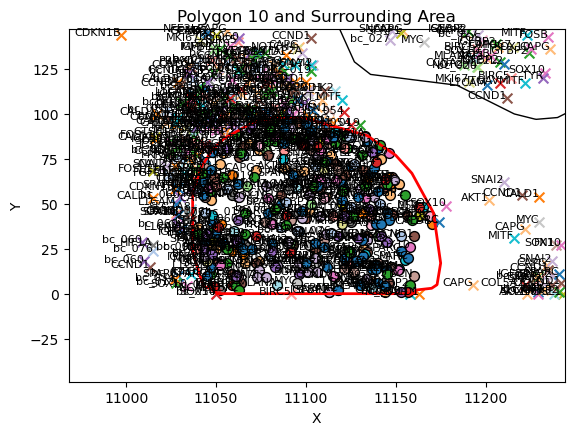

In [38]:
# count number of cells with at least two counts for each gene

np.sum(df[barcode_cols]>2)

NameError: name 'gene_cols' is not defined

In [42]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

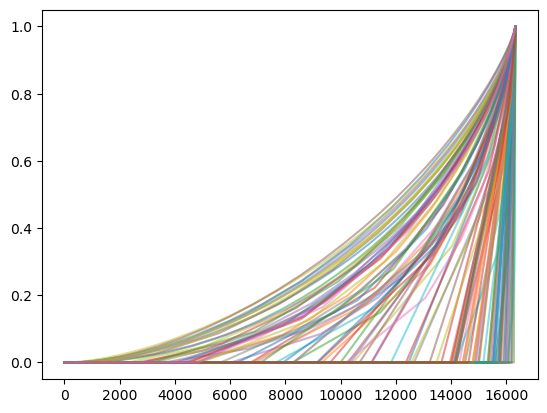

In [52]:


for gene in gene_cols:
    
    plt.plot(np.cumsum(sorted(df[gene].values))/np.sum(df[gene].values),label=gene,alpha=0.5)
    # more_than_1 = df[df[gene]>1]
    # plt.plot(np.cumsum(sorted(more_than_1[gene].values))/np.sum(more_than_1[gene].values),label=gene,alpha=0.5)

In [58]:
my_cutoff = 10

n_high = []
for gene in gene_cols:
    n_high_here = len(df[df[gene]>my_cutoff])
    n_high.append(n_high_here)

    if (n_high_here > 1000) & (n_high_here < 2000):
        print(gene,n_high_here)

AKT1 1313
BIRC5 1354
CTNNB1 1174
FN1 1737
HIF1A 1289


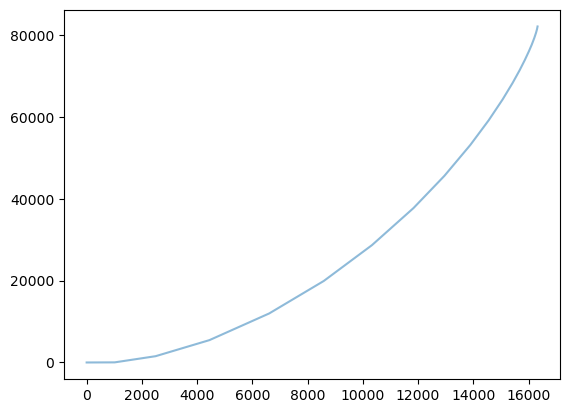

In [69]:
    
plt.plot(np.cumsum(sorted(df['AKT1'].values)),label='AKT1',alpha=0.5)
# plt.yscale('log')

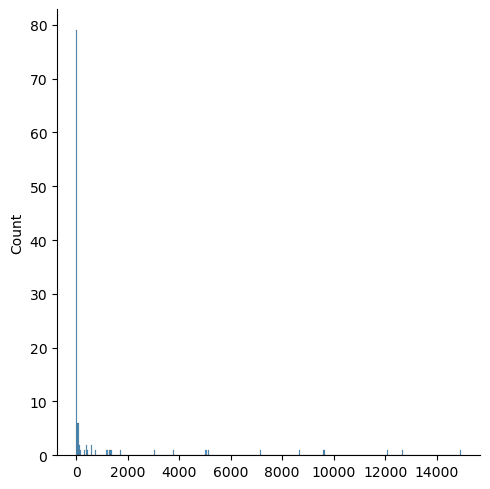

In [57]:
sns.displot(n_high)

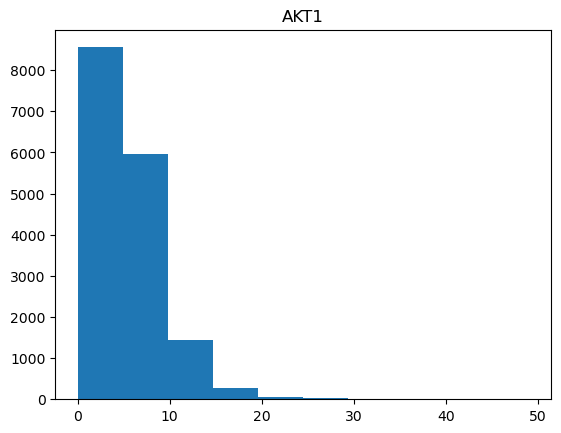

In [34]:
for gene in gene_columns:
    plt.hist(df[gene])
    plt.title(gene)
    plt.show()
    break

In [19]:
sg_obj.show_gene_stats_plots("MMP1")
sg_obj.show_gene_stats_plots("AKT1")
# sg_obj.show_gene_stats_plots("FN1")
# sg_obj.show_gene_stats_plots("AXL")

Statistics for gene MMP1: count    16328.000000
mean         0.084579
std          1.806872
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        119.000000
Name: MMP1, dtype: float64
Number of objects expressing MMP1: 298 out of 16328 (1.83%)


In [3]:
df[df['AKT1']>15]

NameError: name 'df' is not defined

In [36]:
adata_genes = sc.AnnData(df[gene_cols])

In [37]:
adata_genes = sc.AnnData(df[gene_cols])

# sc.pp.normalize_total(adata_genes, target_sum=1e4)

In [38]:
adata_genes.to_df()

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,TRPM1,TYR,VCAM1,VEGFA,VEGFC,VGF,WNT5A,YAP1,ZEB1,ZEB2
object_id,,,,,,,,,,,,,,,,,,,,,
1,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
10,11.0,0.0,2.0,0.0,5.0,0.0,0.0,10.0,28.0,2.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1000,3.0,0.0,0.0,0.0,5.0,0.0,0.0,15.0,30.0,4.0,...,0.0,6.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,1.0
10000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,33.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,100.0,3.0,...,1.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0
9996,2.0,0.0,38.0,0.0,0.0,0.0,0.0,17.0,19.0,0.0,...,1.0,0.0,0.0,22.0,0.0,0.0,7.0,1.0,1.0,0.0
9997,5.0,0.0,0.0,0.0,5.0,0.0,0.0,13.0,25.0,4.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


Now, let's find the highly variable genes. That is, genes that vary across the sample.

In [39]:
## default highly variable gene identification (seurat) is applied to log(1+x) counts
## this normalization 
# sc.pp.log1p(adata_genes)
# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

In [40]:
sc.pl.highly_variable_genes(adata_genes)

In [166]:
seuratv3 = adata_genes.var['highly_variable']

In [44]:
# for entry in adata_genes.var

color_dict = {True:'r',False:'k'}

plt.figure()

plt.scatter(adata_genes.var['means'].values,adata_genes.var['variances_norm'].values,
            marker='.',s=5,color=[color_dict[x] for x in adata_genes.var['highly_variable']])

for gene in adata_genes.var.index:
    if adata_genes.var['highly_variable_rank'].loc[gene] < 10:
        plt.text(adata_genes.var['means'].loc[gene],adata_genes.var['variances_norm'].loc[gene],gene,fontsize=8)

In [ ]:
matplotlib.use('QtAgg')

In [24]:
matplotlib.use('Qt5Agg')
# %matplotlib inline

In [1]:
sg_obj.show_gene_stats_plots('WNT5A')

NameError: name 'sg_obj' is not defined

In [45]:
for gene in adata_genes.var.index:
    if adata_genes.var['highly_variable_rank'].loc[gene] < 5:
        print(gene)
        sg_obj.show_gene_stats_plots(gene)



BGN
Statistics for gene BGN: count    16328.000000
mean         0.085987
std          0.726409
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         38.000000
Name: BGN, dtype: float64
Number of objects expressing BGN: 716 out of 16328 (4.39%)
FN1
Statistics for gene FN1: count    16328.000000
mean         4.646987
std          8.363742
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        170.000000
Name: FN1, dtype: float64
Number of objects expressing FN1: 12748 out of 16328 (78.07%)
IFIT2
Statistics for gene IFIT2: count    16328.000000
mean         0.057937
std          0.535686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: IFIT2, dtype: float64
Number of objects expressing IFIT2: 638 out of 16328 (3.91%)
IGFBP7
Statistics for gene IGFBP7: count    16328.000000
mean         0.291034
std          2.257929
min          0.000

In [147]:
df[df['FN1']>50]

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,nucleus_centroid,nucleus
object_id,,,,,,,,,,,,,,,,,,,,,
10143,11.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,73.0,0.0,...,1.0,0.0,23.0,0.0,10143,"[bc_004, bc_005, bc_022, bc_023, bc_033, bc_04...",9,bc_004-bc_005-bc_022-bc_023-bc_033-bc_041-bc_0...,None,None
10289,11.0,0.0,0.0,0.0,15.0,0.0,0.0,28.0,47.0,6.0,...,0.0,0.0,0.0,0.0,10289,"[bc_025, bc_066]",2,bc_025-bc_066,None,None
10313,13.0,0.0,0.0,0.0,7.0,0.0,0.0,42.0,107.0,1.0,...,0.0,0.0,0.0,0.0,10313,"[bc_002, bc_008, bc_043, bc_046, bc_060, bc_08...",7,bc_002-bc_008-bc_043-bc_046-bc_060-bc_083-bc_084,None,None
1033,13.0,0.0,0.0,0.0,6.0,0.0,0.0,9.0,82.0,3.0,...,0.0,0.0,0.0,0.0,1033,"[bc_024, bc_026, bc_089]",3,bc_024-bc_026-bc_089,None,None
10492,10.0,0.0,0.0,0.0,8.0,0.0,0.0,45.0,195.0,0.0,...,1.0,0.0,0.0,7.0,10492,"[bc_002, bc_007, bc_011, bc_022, bc_024, bc_02...",19,bc_002-bc_007-bc_011-bc_022-bc_024-bc_027-bc_0...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,4.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,42.0,0.0,...,0.0,0.0,18.0,0.0,9676,"[bc_025, bc_056, bc_067, bc_074, bc_079, bc_08...",8,bc_025-bc_056-bc_067-bc_074-bc_079-bc_080-bc_0...,None,None
970,5.0,0.0,2.0,0.0,2.0,0.0,0.0,77.0,13.0,0.0,...,0.0,0.0,0.0,0.0,970,[],0,,None,None
9715,6.0,0.0,0.0,0.0,4.0,0.0,0.0,17.0,78.0,4.0,...,0.0,0.0,0.0,0.0,9715,"[bc_012, bc_019, bc_030, bc_045, bc_057, bc_06...",10,bc_012-bc_019-bc_030-bc_045-bc_057-bc_060-bc_0...,None,None


In [30]:
df[df['MMP1']>10][['MMP1','called_barcodes']]

,MMP1,called_barcodes
object_id,,
10042,24.0,[bc_060]
10099,27.0,"[bc_002, bc_011, bc_020, bc_024, bc_025, bc_03..."
10690,33.0,"[bc_024, bc_035, bc_067, bc_087]"
10795,31.0,"[bc_001, bc_031, bc_041, bc_058, bc_086, bc_09..."
11146,89.0,"[bc_013, bc_020, bc_033, bc_041, bc_047, bc_06..."
11208,27.0,"[bc_003, bc_011, bc_012, bc_047, bc_057, bc_05..."
11230,119.0,"[bc_006, bc_013, bc_041, bc_053, bc_061, bc_089]"
14409,11.0,"[bc_025, bc_040, bc_047, bc_063, bc_083]"
14554,14.0,[]


In [59]:
sg_obj.plot_polygon_and_points('9996',gene_names=['MMP1','bc_060'],annotate=False)

TypeError: plot_polygon_and_points() got an unexpected keyword argument 'annotate'

In [31]:
sg_obj.plot_polygon_and_points('6747',gene_names=['MMP1','bc_001', 'bc_057', 'bc_085'])

In [24]:
sg_obj.plot_polygon_and_points('14424',gene_names=['MMP1','bc_025', 'bc_028', 'bc_040', 'bc_063'])

In [32]:
df[df['IFIT2']>5][['IFIT2','called_barcodes']]

,IFIT2,called_barcodes
object_id,,
1137,18.0,"[bc_057, bc_085, bc_092, bc_095]"
13990,9.0,[]
14003,8.0,"[bc_001, bc_006, bc_007, bc_009, bc_020, bc_04..."
14044,9.0,"[bc_020, bc_033, bc_043, bc_052, bc_058, bc_08..."
14493,6.0,"[bc_041, bc_052]"
15761,6.0,"[bc_014, bc_053, bc_059, bc_088]"
185,8.0,"[bc_039, bc_060, bc_081]"
2273,6.0,[]
2322,17.0,[bc_015]


TypeError: plot_polygon_and_points() missing 1 required positional argument: 'identifier'

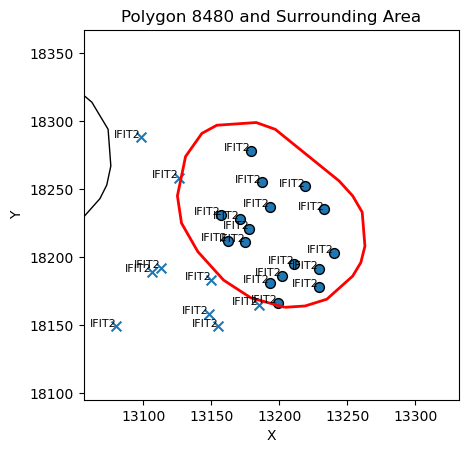

In [142]:
# sg_obj.plot_polygon_and_points('8480',gene_names=['IFIT2']+barcode_cols)
# sg_obj.plot_polygon_and_points('8480',gene_names=['IFIT2']+['bc_009','bc_070','bc_088'])
sg_obj.plot_polygon_and_points('8480',gene_names=['IFIT2'],)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


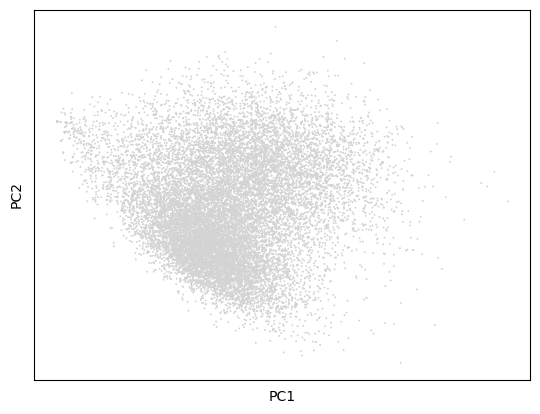

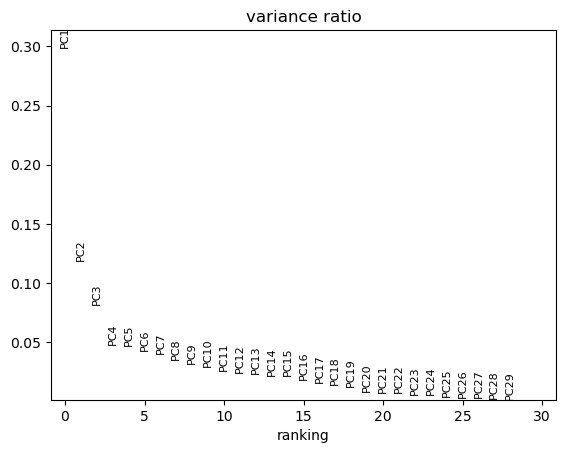

In [149]:

# sc.pp.log1p(adata_genes)
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [150]:
sc.pp.neighbors(adata_genes)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [230]:
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


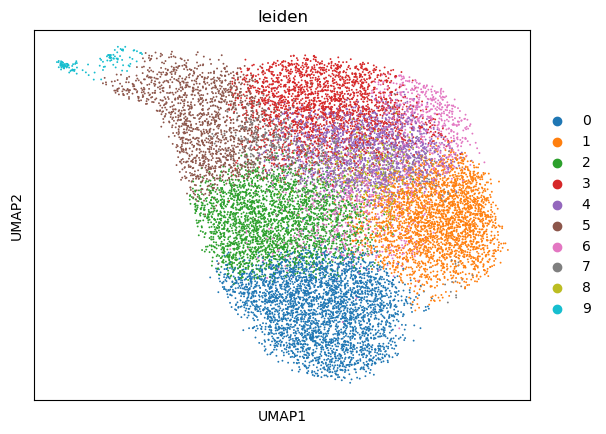

In [231]:
sc.pl.umap(adata_genes, color=["leiden"])

In [232]:
adata_genes.uns['umap']

{'params': {'a': 0.5830300205483709, 'b': 1.334166992455648}}

In [163]:
adata_genes.obsm['X_umap']

array([[11.454764 ,  8.051585 ],
       [12.243902 ,  4.2286735],
       [ 4.485957 , 12.1284   ],
       ...,
       [ 9.816606 ,  7.7067156],
       [ 9.838603 ,  6.8390865],
       [ 8.451407 ,  5.8039436]], dtype=float32)

In [181]:
sister_cells = {}
for bc_set in np.unique(df[df['n_called_barcodes']>4]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 3:

        sister_cells[bc_set] = df[df['barcode_names']==bc_set].index

In [185]:
sister_cells

{'bc_001-bc_010-bc_016-bc_033-bc_079-bc_080-bc_081': Index(['8466', '8891', '8944', '8989', '9402'], dtype='object', name='object_id'),
 'bc_001-bc_017-bc_019-bc_053-bc_086': Index(['1662', '1753', '1975', '2166', '2219'], dtype='object', name='object_id'),
 'bc_001-bc_025-bc_041-bc_057-bc_087-bc_091': Index(['12352', '12436', '12621', '12720'], dtype='object', name='object_id'),
 'bc_001-bc_029-bc_030-bc_068-bc_074': Index(['4994', '5004', '5062', '5197'], dtype='object', name='object_id'),
 'bc_002-bc_024-bc_068-bc_076-bc_084': Index(['6562', '6566', '6639', '7003'], dtype='object', name='object_id'),
 'bc_002-bc_044-bc_052-bc_073-bc_084': Index(['6712', '6760', '6768', '6838'], dtype='object', name='object_id'),
 'bc_003-bc_025-bc_045-bc_066-bc_085-bc_095': Index(['10734', '10740', '10815', '10853'], dtype='object', name='object_id'),
 'bc_003-bc_033-bc_059-bc_074-bc_078': Index(['4751', '4816', '5046', '5123'], dtype='object', name='object_id'),
 'bc_003-bc_034-bc_041-bc_055-bc_088

In [ ]:
sc.pl.umap(adata_genes, color=["leiden"])

for bc_set,ix in sister_cells.items():
    print(bc_set)
    sc.pl.umap(adata_genes, color=["leiden"],groups=ix)
    plt.show()

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


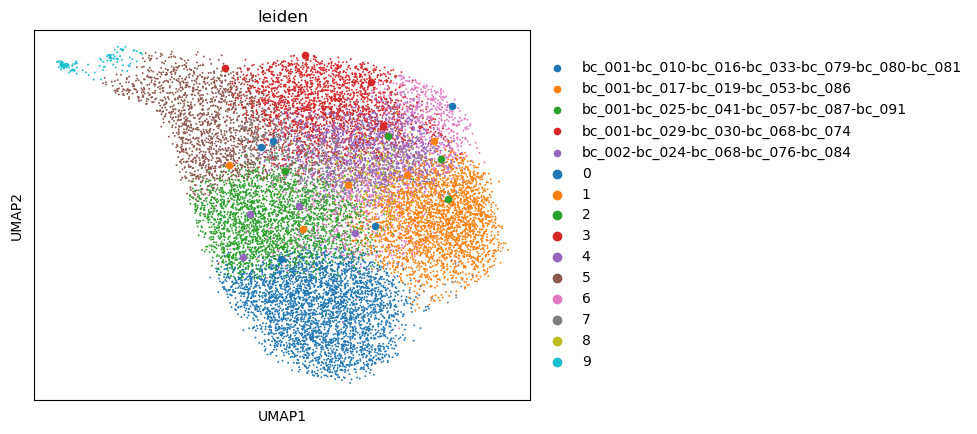

In [213]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 5:
        umap_coords = adata_genes[ix].obsm['X_umap']
        ax.scatter(umap_coords[:,0],umap_coords[:,1],s=20,zorder=10,label=bc_set) 
sc.pl.umap(adata_genes, color=["leiden"],ax=ax)


 

In [ ]:
adata_genes[['6116', '6233', '6462', '6575'].obsm['X_umap  ']

In [205]:
plt.umap_coords[:,0]

ArrayView([9.794292, 7.995223, 9.066204, 9.690912], dtype=float32)

In [216]:
adata_genes

AnnData object with n_obs × n_vars = 16328 × 117
    obs: 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


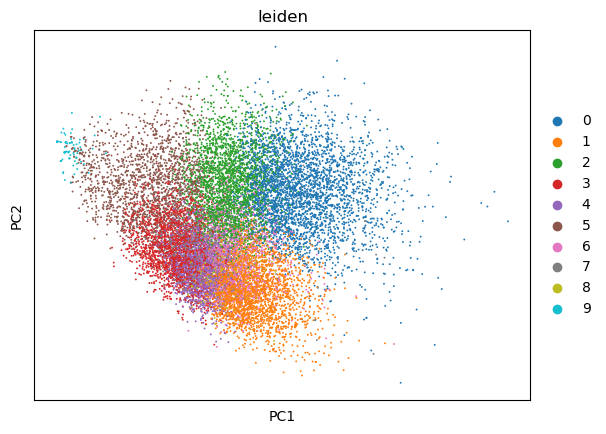

In [233]:
fig,ax = plt.subplots()
# for b,(bc_set,ix) in enumerate(sister_cells.items()):
#     if b < 10:
#         pca_coords = adata_genes[ix].obsm['X_pca']
#         ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,color='leiden')
# ax.legend()
# fig.savefig('pca_sister_cells.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells.png',dpi=300,bbox_inches='tight')

In [235]:
sc.tl.rank_genes_groups(adata_genes, groupby="leiden", method="wilcoxon")

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


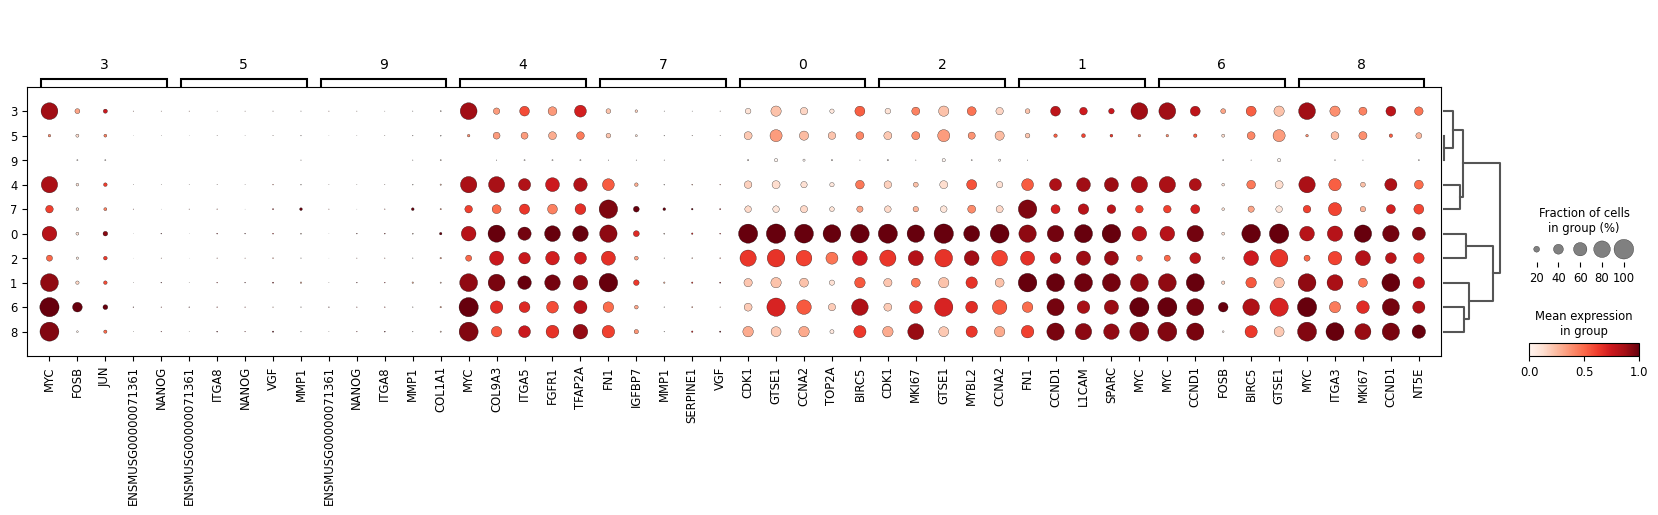

In [237]:
sc.pl.rank_genes_groups_dotplot(
    adata_genes, groupby="leiden", standard_scale="var", n_genes=5
)

In [242]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [243]:
cell_cycle_genes

['CDK1', 'BIRC5', 'TOP2A', 'MKI67', 'GTSE1']

In [245]:
[gene for gene in cell_cycle_genes if gene in s_genes]

[]

In [238]:
sc.tl.score_genes_cell_cycle(adata_genes)

TypeError: score_genes_cell_cycle() missing 2 required positional arguments: 's_genes' and 'g2m_genes'

In [248]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


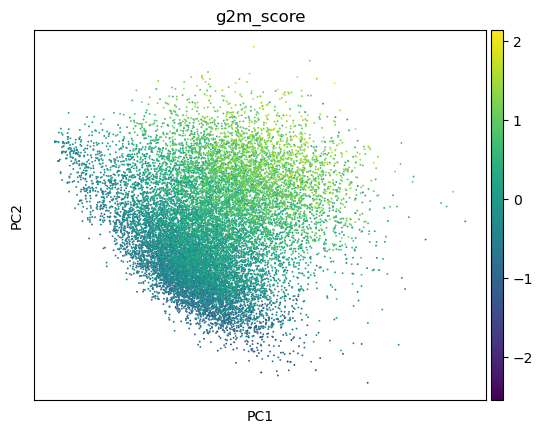

In [249]:
sc.pl.pca(adata_genes,color='g2m_score')

In [251]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

In [252]:
sc.tl.pca(adata_genes)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


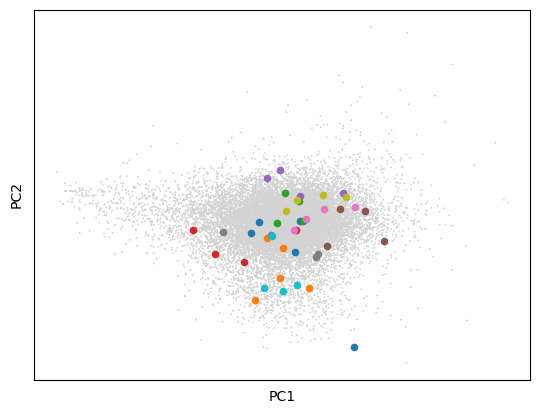

In [262]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,2')
# ax.legend()
# fig.savefig('pca_sister_cells_G2Mregressed.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells_G2Mregressed.png',dpi=300,bbox_inches='tight')

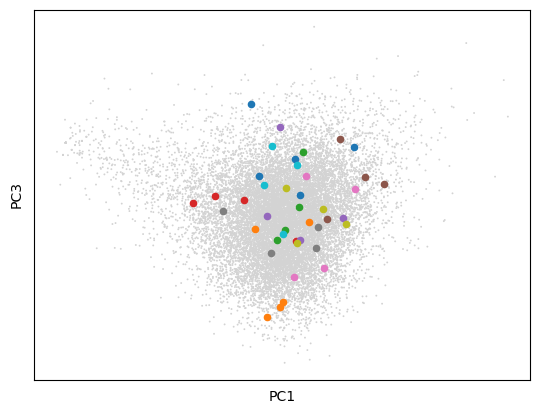

In [261]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,2],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,3')

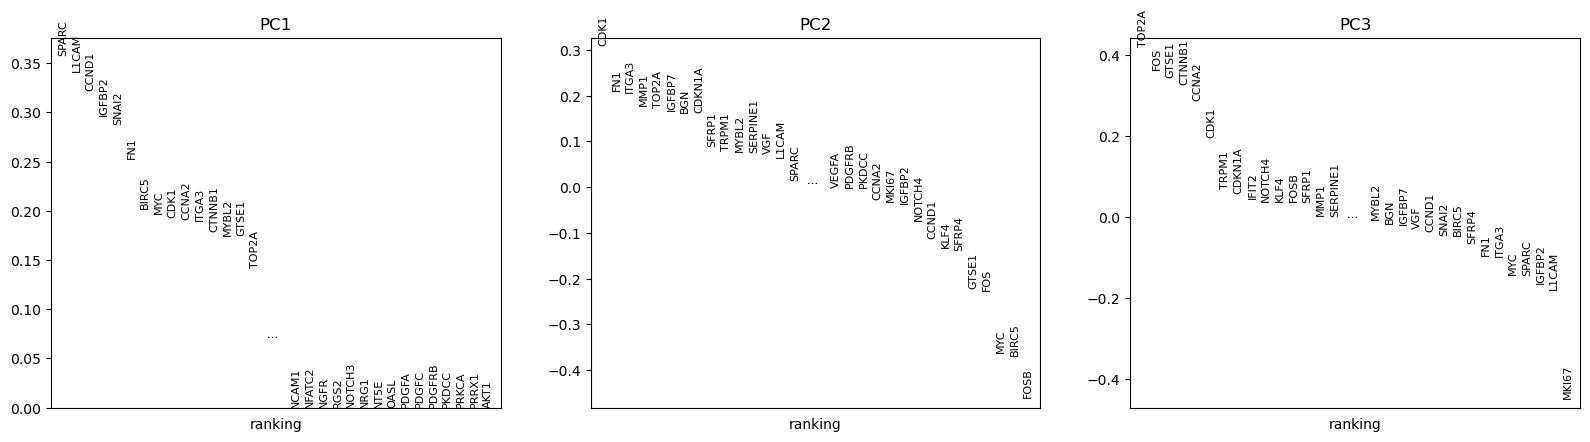

In [256]:
sc.pl.pca_loadings(adata_genes)

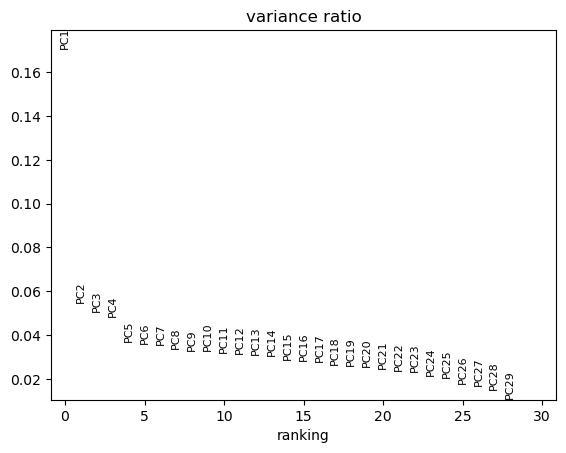

In [263]:
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [264]:
sister_cells_more = {}
for bc_set in np.unique(df[df['n_called_barcodes']>3]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 1:

        sister_cells_more[bc_set] = df[df['barcode_names']==bc_set].index

In [265]:
sister_cells_more

{'bc_001-bc_002-bc_007-bc_013-bc_059-bc_066-bc_075-bc_083-bc_084': Index(['8129', '8190'], dtype='object', name='object_id'),
 'bc_001-bc_002-bc_028-bc_067-bc_081-bc_095': Index(['14314', '14336'], dtype='object', name='object_id'),
 'bc_001-bc_002-bc_030-bc_041-bc_083': Index(['8236', '8301'], dtype='object', name='object_id'),
 'bc_001-bc_002-bc_060-bc_091': Index(['7282', '7687'], dtype='object', name='object_id'),
 'bc_001-bc_003-bc_006-bc_060-bc_064-bc_070': Index(['10714', '11050'], dtype='object', name='object_id'),
 'bc_001-bc_003-bc_015-bc_037-bc_043-bc_047-bc_063': Index(['8329', '8356'], dtype='object', name='object_id'),
 'bc_001-bc_003-bc_022-bc_068-bc_090': Index(['11335', '11344', '11380'], dtype='object', name='object_id'),
 'bc_001-bc_003-bc_035-bc_058-bc_070-bc_092': Index(['5145', '5170', '5261'], dtype='object', name='object_id'),
 'bc_001-bc_004-bc_005-bc_009-bc_038-bc_066': Index(['10179', '10208', '10308'], dtype='object', name='object_id'),
 'bc_001-bc_004-bc_02

In [352]:
sister_more_dists = []
randos = []

all_ids = df.index

pcs_to_use = 2

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
    # if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']

        d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        sister_more_dists.append(np.mean(d))


        pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
        d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        randos.append(np.mean(d))


# n_sims = 1000

# randos = np.zeros((n_sims,len(sister_cells_more)))

# for n in range(n_sims):
#     for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
#         # if b < 10:
#             # pca_coords = adata_genes[ix].obsm['X_pca']

#             # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
#             # sister_more_dists.append(np.mean(d))


#             pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
#             d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
#             randos[n,b] = np.mean(d)






Text(0.5, 0, 'Mean distance between sisters')

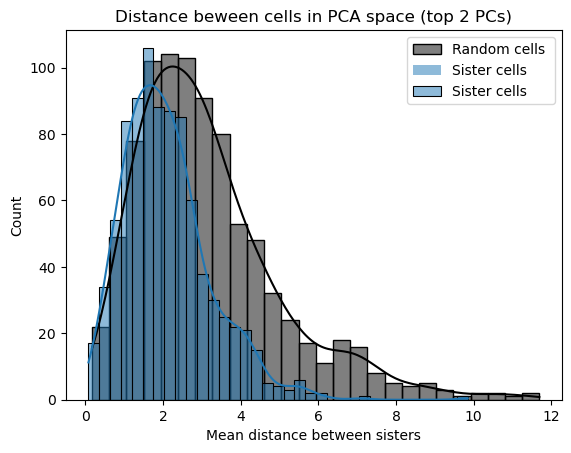

In [353]:
fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



Text(0.5, 0, 'Mean distance between sisters')

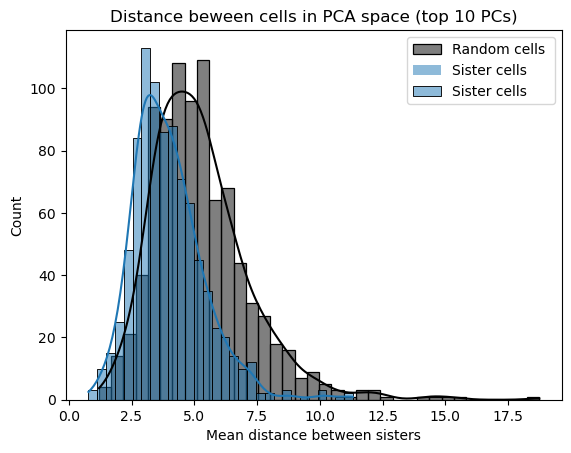

In [347]:
fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



We can ask whether sisters on average are closer in gene expression than expected by chance. 
To do this, we can calculate an empirical distribution of expected average distance in the PC space for equivalent sized groups and ask how rare it would be to observe what we see for the sisters.

In [325]:
sister_more_dists = []
randos = []

all_ids = df.index

pcs_to_use = 10

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
    # if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']

        d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        sister_more_dists.append(np.mean(d))


        # pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
        # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        # randos.append(np.mean(d))

n_sims = 100

randos = np.zeros((n_sims,len(sister_cells_more)))

for n in range(n_sims):
    for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
        # if b < 10:
            # pca_coords = adata_genes[ix].obsm['X_pca']

            # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
            # sister_more_dists.append(np.mean(d))


            pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
            d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
            randos[n,b] = np.mean(d)



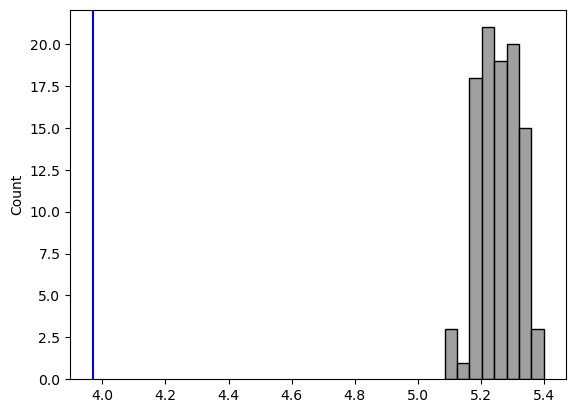

In [326]:
fig,ax = plt.subplots()
sns.histplot(np.mean(randos,axis=1),ax=ax,color='gray')
plt.axvline(np.mean(sister_more_dists),color='b')
# sns.histplot(sister_more_dists,ax=ax)

As you can see, from our 100 simulations, we never observe as extreme a trend as we do for the sisters. This gives an empirical p-value of p<0.01 (we could simulate more to get essentially as low a p-value as we want because there is very strong separation).

In [292]:
len(np.mean(randos,axis=1))

100

<AxesSubplot: ylabel='Count'>

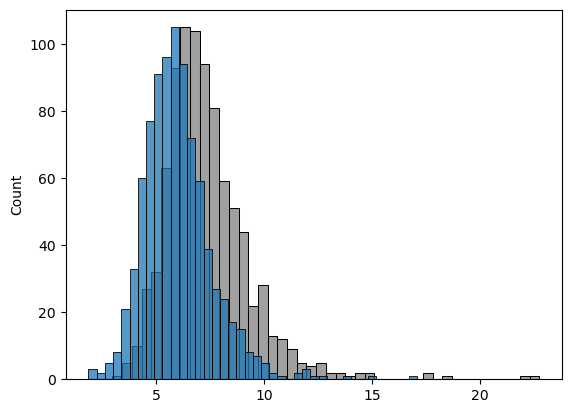

In [301]:
n_sisters  = []
sister_more_dists = []

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
    # if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']

        d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        sister_more_dists.append(np.mean(d))
        n_sisters.append(len(ix))


        # pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
        # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        # randos.append(np.mean(d))

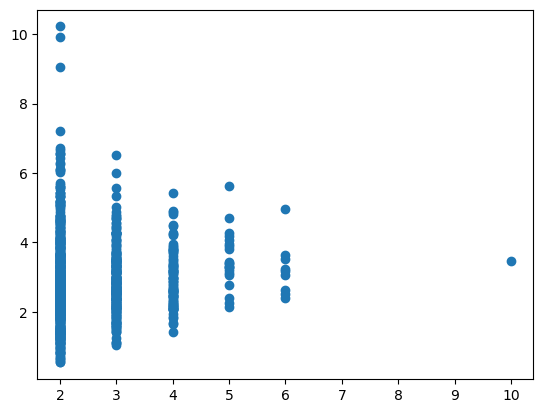

In [296]:
plt.scatter(n_sisters,sister_more_dists)

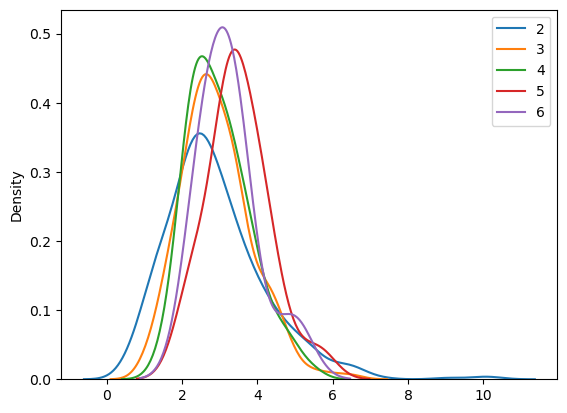

In [324]:
for n in [2,3,4,5,6]:
    # locations with this many sisters
    ix = np.where(np.array(n_sisters) == n)[0]
    sister_dists_here = [sister_more_dists[i] for i in ix]
    # sns.histplot(sister_dists_here,label=n,stat='density')
    sns.kdeplot(sister_dists_here,label=n)
plt.legend()

In [300]:
ix

array([0])